In [1]:
%matplotlib inline
import cv2 
import imageio
import pickle
import pydicom
import random
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from scipy.sparse import csr_matrix

import sys
sys.path.append('../metal')

In [2]:
def OCIndex2Label(index_open, index_close):
    """
    Converts from open and close index to frame-wise labels   
    
    Params
    -------
    index_open: int
    index_close: int
    
    Return
    -------
    frame_labels: numpy array of shape (1,50)
    
    """
    index_open = int(index_open)
    index_close = int(index_close)
    
    frame_labels = np.zeros([1,50]);
    if(index_close >= index_open):
        frame_labels[0,index_open:index_close] = 1
    else:
        frame_labels[0,index_open:50] = 1
        frame_labels[0,0:index_close] = 1
        
    return frame_labels   

In [3]:
def plotLabel(label_list, yaxis):
    '''
    Function to plot labels derived using a labelling function. 
    
    Input
    -----
    label_list: list shape (50,1)
    yaxis: string
    
    '''
    plt.figure()
    plt.plot(np.arange(len(label_list)),label_list)
    plt.xlabel('frame number')
    plt.ylabel(yaxis)
    plt.title(yaxis)


In [4]:
def findAreaLabel(mask):
    '''
    function to find labels based on area of left atrium
    
    Input
    -----
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    area_la = np.sum(np.sum(mask==1.0,axis=2),axis=1) # area of left atrium
    
    area_thresh_high = 550
    area_thresh_low = 470
    
    label = np.zeros([1,50])
    label[:,(area_la < area_thresh_low) ] = 1
    label[:,(area_la > area_thresh_high) ] = 2
    
    return label

In [15]:
def findPerimeterLabel(mask):
    '''
    function to find labels based on perimeter of left atrium
    
    Input
    -----
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    
    label = np.zeros([50,1])
    perimeter_thresh_high = 99
    perimeter_thresh_low = 92
    
    # finding perimeter of left atrium 
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    perimeter = 0.5*(perimeter_thresh_high+perimeter_thresh_low)*np.ones((50,1))
    for frame in range(50):
        regions = regionprops(mask[frame])
        if regions:
            perimeter[frame] = regions[0].perimeter          
    
    label[(perimeter < perimeter_thresh_low) ] = 1
    label[(perimeter > perimeter_thresh_high) ] = 2
    
    return np.transpose(label)

In [26]:
def findIntensityLabel(data, mask):
    '''
    function to define labels based on intensity within left atrium
    
    Input
    -----
    data: float (50,208,174)
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    # avg intensity within segment
    mask[mask!=1.0] = 0.0
    area_intensity = np.mean(np.mean(np.multiply(mask,data),axis=2),axis=1)
        
    area_intensity_thresh_high = 4.4
    area_intensity_thresh_low = 3.2
        
    label = np.zeros([1,50])
    label[:,(area_intensity < area_intensity_thresh_low) ] = 1
    label[:,(area_intensity > area_intensity_thresh_high) ] = 2
    
    return label

In [25]:
def findIntensityLabel2(data, mask):
    '''
    function to define labels based on intensity along perimeter of left atrium
    
    Input
    -----
    data: float (50,208,174)
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    # avg intensity within segment
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    boundary = find_boundaries(mask,mode='outer')
    intensity = np.mean(np.mean(np.multiply(boundary,data),axis=2),axis=1)
       
    perimeter_intensity_thresh_high = 0.86
    perimeter_intensity_thresh_low = 0.72
    label = np.zeros([1,50])
    label[:,(intensity < perimeter_intensity_thresh_low) ] = 1
    label[:,(intensity > perimeter_intensity_thresh_high) ] = 2
    
    return label

In [12]:
def findLabelPrior():
    index_open = 20
    index_close = 1
    
    label = OCIndex2Label(index_open,index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    low_margin = 3
    high_margin = 2
    label[:,index_open-low_margin:index_open+high_margin] = 0
    index_low = (index_close-low_margin)%50
    index_high = (index_close+high_margin)%50
    
    if(index_close+high_margin < 50 and index_close-low_margin >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
        
    return label

In [13]:
# load labels, data and masks
# change path to where data is
#path = '/Users/ashwiniramamoorthy/Desktop/Heart_MRI/data/'
path = '../data/'
with open(path+'all_labels.pickle', 'rb') as handle:
    labels = pickle.load(handle)

with open(path+'data.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
with open(path+'mask.pickle', 'rb') as handle:
    mask = pickle.load(handle)

1476888


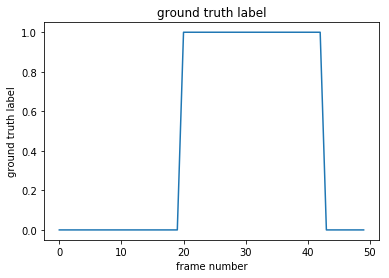

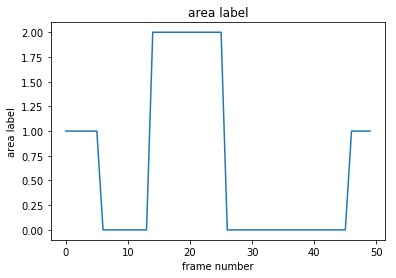

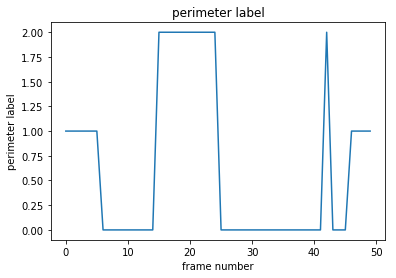

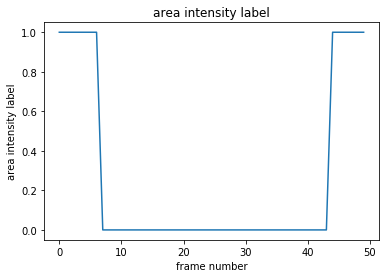

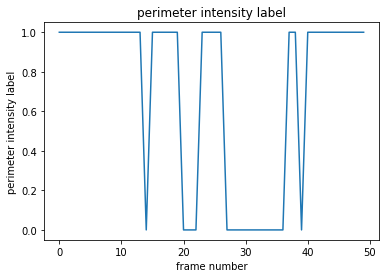

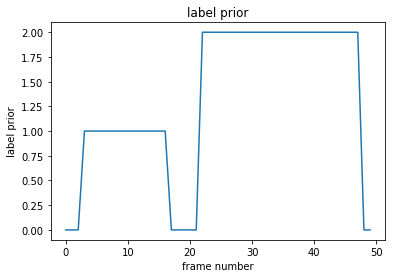

In [27]:
# plotting the label measure vs frame for a single example
eg_key = list(labels.keys())[0]
print(eg_key)

# printing ground truth label of the eg
start_frame, end_frame = labels[eg_key]
eg_true_label = np.transpose(OCIndex2Label(start_frame,end_frame))
plotLabel(eg_true_label, 'ground truth label')

# computing area label
eg_area_label = np.transpose(findAreaLabel(mask[eg_key]))
plotLabel(eg_area_label, 'area label')

# computing perimeter label 
eg_perimeter_label = np.transpose(findPerimeterLabel(mask[eg_key]))
plotLabel(eg_perimeter_label, 'perimeter label')

# computing area intensity label 
eg_intensity_label = np.transpose(findIntensityLabel(data[eg_key], mask[eg_key]))
plotLabel(eg_intensity_label, 'area intensity label')

# computing perimeter intensity label 
eg_intensity2_label = np.transpose(findIntensityLabel2(data[eg_key], mask[eg_key]))
plotLabel(eg_intensity2_label, 'perimeter intensity label')

# using frame number to define frame label prior
label_prior = np.transpose(findLabelPrior())
plotLabel(label_prior, 'label prior')


In [28]:
#computing labels for all subjects
image_labels = np.zeros((len(labels),50))
area_labels = np.zeros((len(labels),50))
perimeter_labels = np.zeros((len(labels),50))
intensity_labels = np.zeros((len(labels),50))
intensity2_labels = np.zeros((len(labels),50))
label_prior = np.zeros((len(labels),50))

for iter in range(len(labels)):
    PID = list(labels.keys())[iter]
    print(PID)
    
    start_frame, end_frame = labels[PID]
    image_labels[iter,:] = OCIndex2Label(start_frame,end_frame)
    area_labels[iter,:] = findAreaLabel(mask[PID])
    perimeter_labels[iter,:] = findPerimeterLabel(mask[PID])
    intensity_labels[iter,:] = findIntensityLabel(data[PID], mask[PID])
    intensity2_labels[iter,:] = findIntensityLabel2(data[PID], mask[PID])
    label_prior[iter,:] = findLabelPrior()

1476888
1192908
1306467
1629308
2106029
2774599
3284626
1052327
2977350
2686576
3134226
5456802
4471596
5142661
5441523
5842628
2283643
5871626
3079449
3873369
4618076
5684778
1484554
3871554
3556300
3442724
4694866
1865913
5180537
4992065


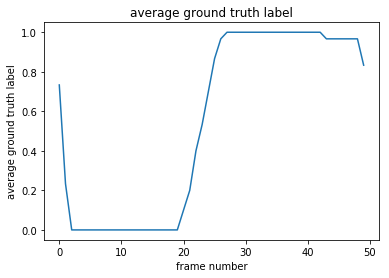

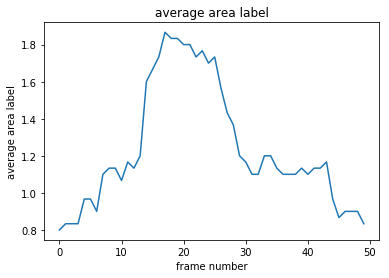

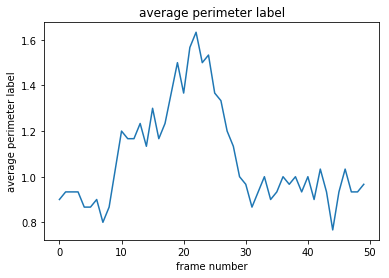

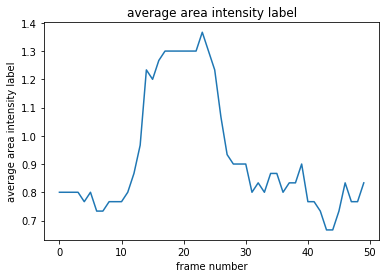

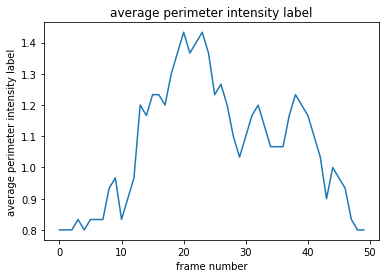

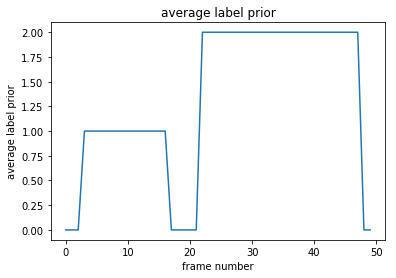

In [29]:
# plotting average labels
plotLabel(np.mean(image_labels,axis=0), 'average ground truth label')
plotLabel(np.mean(area_labels,axis=0), 'average area label')
plotLabel(np.mean(perimeter_labels,axis=0), 'average perimeter label')
plotLabel(np.mean(intensity_labels,axis=0), 'average area intensity label')
plotLabel(np.mean(intensity2_labels,axis=0), 'average perimeter intensity label')
plotLabel(np.mean(label_prior,axis=0), 'average label prior')

In [30]:
# evaluating labelling functions using metal metrics
L = np.stack((area_labels, perimeter_labels, intensity_labels, intensity2_labels, label_prior),axis=2) #(30,50,5)
Y = image_labels # (30,50)

# reshaping 
L = np.reshape(L,(len(labels)*50,5)) # (1500,5)
Y = Y.flatten() #(1500,)

# using metal indexing
Y = Y+1

from metal.analysis import lf_summary
lf_summary(csr_matrix(L),csr_matrix(Y))

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,"[1.0, 2.0]",0.782667,0.781333,0.347333,574,600,0.488927
1,"[1.0, 2.0]",0.754667,0.750000,0.343333,532,600,0.469965
2,"[1.0, 2.0]",0.620667,0.620667,0.228667,475,456,0.510204
3,"[1.0, 2.0]",0.739333,0.736000,0.361333,592,517,0.533814
4,"[1.0, 2.0]",0.800000,0.768667,0.418667,1149,51,0.957500
